# **Imports**

In [1]:
!pip install albumentations==1.3.0
!pip install segmentation-models-pytorch==0.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.5
    Uninstalling albumentations-2.0.5:
      Successfully uninstalled albumentations-2.0.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9

In [2]:
# Standard library
import os
import gc
import time
import math
import random
import logging
import warnings
logging.basicConfig(level=logging.ERROR)

# Scientific computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Deep learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.parametrizations import weight_norm
from sklearn.metrics import pairwise_distances

# Computer vision
import cv2
import torchvision
from PIL import Image
from torchvision import transforms

# Miscellaneous utilities
from tqdm import tqdm
import timm
import einops
from einops import rearrange
from sklearn.model_selection import KFold
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
import kagglehub

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 10
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
IMAGE_SIZE = 32
NUM_CLASSES = 3
SEED = 42
N_FOLDS = 5

In [4]:
path = kagglehub.dataset_download("khanhpt1999/data-1")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/data-1


# **Model**

In [5]:
img = Image.open("/kaggle/input/test-images/image_2025-05-05_142003010.png").convert("RGB")
print("PIL image size:", img.size, "mode:", img.mode)

transform = transforms.Compose([
    transforms.Resize((32, 32)),        
    #transforms.CenterCrop(224),           
    transforms.ToTensor(),                
    transforms.Normalize( 
        mean=[0.5,0.5,0.5],
        std=[0.5,0.5,0.5]
    ),
])

inpt: torch.Tensor = transform(img)
print("Tensor shape:", inpt.shape, "dtype:", inpt.dtype, "range:", inpt.min(),"→",inpt.max())

PIL image size: (1080, 608) mode: RGB
Tensor shape: torch.Size([3, 32, 32]) dtype: torch.float32 range: tensor(-0.9843) → tensor(0.9765)


In [6]:
inpt = inpt.unsqueeze(0)
print(f"Shape of Input: {inpt.shape}")

Shape of Input: torch.Size([1, 3, 32, 32])


In [7]:
import torch
import torch.nn as nn
import math

class ElectricForceModel(nn.Module):

    def __init__(
        self,
        imsize = 32,
        epsilon=1,
        v0 = 0,
        layers = 3,
        loops = 4,
        debug = False,
        mass = 1,
        time = 1,
        beta = 0.5,
    ):
        super().__init__()

        self.register_buffer('v0', torch.tensor([v0], dtype=torch.float32))
        self.register_buffer('epsilon', torch.tensor([epsilon], dtype=torch.float32))
        self.register_buffer('time', torch.tensor([time], dtype=torch.float32))
        self.register_buffer('mass', torch.tensor([mass], dtype=torch.float32))
        self.register_buffer('beta', torch.tensor([beta], dtype=torch.float32))
        
        self.imsize = imsize
        self.layers = layers
        self.loops = loops
        self.debug = debug

        self.mapping_to_vector_space = nn.Conv2d(3, 2, 1, 1, 0)
        self.space_norm = nn.Tanh()
        self.mapping_to_ipt = nn.Conv2d(2, 3, 1, 1, 0)

    def compute_distance(self, ipt):
        
        """
        Compute the distance of each point with respect to every point in zeta

        Input:
            - ipt: Input Image | [B, 3, self.imsize, self.imsize]

        Outpt:
            - zeta: The coordinates map for each pixel in image (x, y) | [B, 2, self.imsize, self.imsize]
            - x: x-coordinates of every point in zeta | [B, N]
            - y: y-coordinates of every point in zeta | [B, N]
            - inverse_sq_dist: 1/r^2, the inverse squared distance of each point with respect to every point in zeta | [B, N, N]
            - inverse_dist: 1/r, the inverse distance of each point with respect to every point in zeta | [B, N, N]
            
        How the Function Works:
            - Find zeta using a point-wise-convolutional-layer, the number of channel output will be the number of dimensions in vector space
                            (2 -> (x, y) == Vector Space
                             3 -> (x, y, z) == 3D Space
                             ...
                             ...
                            )
            - Find x and y by slicing zeta along the 0th and 1st of the 1st Dimension
            - Calculate the Euclidean Distance between each point in zeta
            - inverse_sq_dist is D**(-2) and inverse_dist is D**(-1)
        """
        
        if self.debug:
            print(f"Running compute_distance...")
            print(f" ")
            print(f"ipt Shape: {ipt.shape}") # [B, 3, self.imsize, self.imsize]
        
        zeta = self.mapping_to_vector_space(ipt) # [B, 2, self.imsize, self.imsize]
        zeta = self.space_norm(zeta) # [B, 2, self.imsize, self.imsize]
        if self.debug:
            print(f"zeta Shape: {zeta.shape}")

        B, C, H, W = zeta.shape
        N = H*W

        pts = zeta.view(B, 2, N) # [B, 2, N]
        if self.debug:
            print(f"pts Shape: {pts.shape}")

        x, y = pts[:, 0], pts[:, 1] # [B, N], [B, N]
        if self.debug:
            print(f"x Shape: {x.shape}")
            print(f"y Shape: {y.shape}")

        zflat = pts.permute(0, 2, 1) # [B, N, 2]
        if self.debug:
            print(f"zflat Shape: {zflat.shape}")

        D = torch.cdist(zflat, zflat, p=2)
        D = torch.where(D==0, float('inf'), D) # [B, N, N]
        if self.debug:
            print(f"D Shape: {D.shape}")

        inverse_sq_dist = D.pow(-2) # [B, N, N]
        inverse_dist = D.pow(-1) # [B, N, N]
        if self.debug:
            print(f"inverse_sq_dist Shape: {inverse_sq_dist.shape}")
            print(f"inverse_dist Shape: {inverse_dist.shape}")
            
        if self.debug:
            print("-"*59)
        
        return zeta, x, y, inverse_sq_dist, inverse_dist

    def compute_angle(self, x, y):
        
        """
        Compute angle of forces acted on each point with respect to the x-axis
        Input: 
            - x: x-coordinates of every point in zeta | [B, N]
            - y: y-coordinates of every point in zeta | [B, N]

        Output:
            - theta_rad: Radian of angle of forces with respect to the x-axis | [B, N, N]

        How the Function Works:
            - Applying Inverse Function of tan to find the angle | tan = dy/dx
        """
        
        theta_rad = torch.atan2( # [B, N, N]
            y.unsqueeze(2) - y.unsqueeze(1), # [B, N, 1] - [B, 1, N]
            x.unsqueeze(2) - x.unsqueeze(1), # [B, N, 1] - [B, 1, N]
        )
        theta_deg = theta_rad * (180.0 / math.pi) # [B, N, N]
        if self.debug:
            print(f"Running compute_angle...")
            print(f" ")
            print(f"theta_rad Shape: {theta_rad.shape}")
            print(f"theta_deg Shape: {theta_deg.shape}")
            
        if self.debug:
            print("-"*59)
        return theta_rad

    def compute_electric_force(self, ipt, theta_rad, inverse_sq_dist):
        
        """
        Compute the Net Electric Force acted on each point.

        Input:
            - ipt: Input Image | [B, 3, self.imsize, self.imsize]
            - theta_rad: The angle of forces acted on each point with respect to the x-axis | [B, N, N]
            - inverse_sq_dist: 1/r^2, the inverse squared distance of each point with respect to every point in zeta | [B, N, N]

        Output:
            - Fx: Force acted on each point in the x-axis | [B, N]
            - Fy: Force acted on each point in the y-axis | [B, N]

        How the Function Works:
            - F_E = qE = qi (k_E sum(qj/r^2))
                + Since all variables are vectors, we split them into x and y axis, respectively
        """
        
        k_E = 1.0 / (4.0 * math.pi * self.epsilon)
        
        B, C, H, W = ipt.shape
        N = H*W
        
        ipt_reshaped = ipt.view(B, N, C) # [B, N, C]
        
        qi_qj = ipt_reshaped.unsqueeze(2) * ipt_reshaped.unsqueeze(1) # [B, N, 1, C] * [B, 1, N, C] -> [B, N, N, C]
        qi_qj = torch.mean(qi_qj, dim = 3) # [B, N, N]
        if self.debug:
            print(f"Running compute_electric_force...")
            print(" ")
            print(f"qi_qj Shape: {qi_qj.shape}")

        Fx = k_E * qi_qj * inverse_sq_dist * torch.cos(theta_rad) # [B, N, N]
        Fy = k_E * qi_qj * inverse_sq_dist * torch.sin(theta_rad) # [B, N, N]

        Fx = torch.sum(Fx, dim = 2) # [B, N]
        Fy = torch.sum(Fy, dim = 2) # [B, N]
        
        if self.debug:
            print(f"Fx Shape: {Fx.shape}")
            print(f"Fy Shape: {Fy.shape}")
            print("-"*59)
            
        return Fx, Fy

    def compute_vector_translation(self, Fx, Fy, zeta):
        """
        Move each point in the vector space corresponding to forces acted on it.

        Input:
            - Fx: Force acted on each point in the x-axis | [B, N]
            - Fy: Force acted on each point in the y-axis | [B, N]
            - zeta: Coordinates of each point (x, y) | [B, 2, self.imsize, self.imsize]

        Output:
            - zeta: Fully updated Coordinates of each point (x, y) | [B, 2, self.imsize, self.imsize]

        How the Function Works:
            - Displacement = Velocity x time + Initial Position -> D =  vt + x0
            - v = Acceleration x time + Initial Velocity = at + v0
            - Acceleration = Force/Mass = F/m
                + Since all variables are vectors, we split them into x and y axis, respectively
        """
        
        if self.debug:
            print(f"Starting compute_vector_translation...")
            print(" ")
            
        ax = Fx / self.mass # [B, N]
        ay = Fy / self.mass # [B, N]
        if self.debug:
            print(f"ax Shape: {ax.shape}")
            print(f"ay Shape: {ay.shape}")
            
        B, N = Fx.shape
        v0 = self.v0.expand(B, N) # [B, N]
        
        if self.debug:
            print(f"v0 Shape: {v0.shape}")
            
        vx = v0 + ax * self.time # [B, N]
        vy = v0 + ay * self.time # [B, N]
        vx = vx.reshape(B, self.imsize, self.imsize) # [B, self.imsize, self.imsize]
        vy = vy.reshape(B, self.imsize, self.imsize) # [B, self.imsize, self.imsize]
        if self.debug:
            print(f"vx Shape: {vx.shape}")
            print(f"vy Shape: {vy.shape}")
            
        if self.debug:
            print(f"zeta Shape: {zeta.shape}")
            print(f"zeta[:, 0] Shape: {zeta[:, 0].shape}")
            print(f"zeta[:, 1] Shape: {zeta[:, 1].shape}")
        zeta[:, 0] += vx # [B, 2, self.imsize, self.imsize]
        zeta[:, 1] += vy # [B, 2, self.imsize, self.imsize]

        
        if self.debug:
            print(f"Updated zeta Shape: {zeta.shape}")
            print(f"-"*59)
            
        return zeta

    def update_input(self, ipt, zeta):
        
        """
        Update Input by Unmapping zeta

        Input:
            - ipt: Input Image | [B, 3, self.imsize, self.imsize]
            - zeta: Coordinates of each point (x, y) | [B, 2, self.imsize, self.imsize]

        Output:
            - ipt: New Input Image | [B, 3, self.imsize, self.imsize]

        How the Function Works:
            - You got the new zeta Coordinates
            - You unmap it using a point-wise-convolutional-layer
            - New Input will be the summation of the unmapped zeta and the Input Image
        """
        if self.debug:
            print(f"Running update_input...")
            
        map_to_ipt = self.mapping_to_ipt(zeta) # [B, 3, self.imsize, self.imsize]
        ipt = map_to_ipt*self.beta + ipt*(1-self.beta) # [B, 3, self.imsize, self.imsize]
        return ipt

    def compute_energy_of_system(self, ipt, inverse_dist):

        """
        Compute total Energy of the System

        Input:
            - ipt: Final Input Image | [B, 3, self.imsize, self.imsize]
            - inverse_dist: 1/r, the inverse distance of each point with respect to every point in zeta | [B, N, N]
        
        Output:
            - V: Total Energy of Final Input Image | [B]

        How the Function Works:
            - V = sum(qi * Vj) = qi (k_E sum(qj/r^2))
        """
        
        k_E = 1.0 / (4.0 * math.pi * self.epsilon)
        
        B, C, H, W = ipt.shape
        N = H*W
        
        ipt_reshaped = ipt.view(B, N, C) # [B, N, C]
        
        qi_qj = ipt_reshaped.unsqueeze(2) * ipt_reshaped.unsqueeze(1) # [B, N, 1, C] * [B, 1, N, C] -> [B, N, N, C]
        qi_qj = torch.mean(qi_qj, dim = 3) # [B, N, N]
        if self.debug:
            print(f"Running compute_energy_of_system...")
            print(" ")
            print(f"qi_qj Shape: {qi_qj.shape}")

        V = k_E * qi_qj * inverse_dist

        V = torch.sum(V, dim = 2) # [B, N]
        V = torch.sum(V, dim = 1) # [B]
        
        if self.debug:
            print(f"V Shape: {V.shape}")
            print("-"*59)
            
        return V
            
    def forward(self, ipt):
        assert ipt.shape[2] and ipt.shape[3] == self.imsize, "Input Shape's Height and Width must match parameter imsize"
        for layer in range(self.layers):
            if self.debug:
                print(f"Running Layer {layer + 1}/{self.layers}")
                print(f"-"*59)
            for loop in range(self.loops):
                if self.debug:
                    print(f"Starting {loop + 1}/{self.loops} for compute_electric_force...")
                    print(" ")
                zeta, x, y, inverse_sq_dist, inverse_dist = self.compute_distance(ipt)
                theta_rad = self.compute_angle(x, y)
                Fx, Fy = self.compute_electric_force(ipt, theta_rad, inverse_sq_dist)
                zeta = self.compute_vector_translation(Fx, Fy, zeta)
  
            zeta = self.space_norm(zeta)
            ipt = self.update_input(ipt, zeta)

        zeta, _, _, _, inverse_dist = self.compute_distance(ipt)
        V = self.compute_energy_of_system(ipt, inverse_dist)
        
        return ipt, zeta, V

In [8]:
model = ElectricForceModel(debug = True)
model = model.to(DEVICE)

out, zeta, V = model(inpt.to(DEVICE))

Running Layer 1/3
-----------------------------------------------------------
Starting 1/4 for compute_electric_force...
 
Running compute_distance...
 
ipt Shape: torch.Size([1, 3, 32, 32])
zeta Shape: torch.Size([1, 2, 32, 32])
pts Shape: torch.Size([1, 2, 1024])
x Shape: torch.Size([1, 1024])
y Shape: torch.Size([1, 1024])
zflat Shape: torch.Size([1, 1024, 2])
D Shape: torch.Size([1, 1024, 1024])
inverse_sq_dist Shape: torch.Size([1, 1024, 1024])
inverse_dist Shape: torch.Size([1, 1024, 1024])
-----------------------------------------------------------
Running compute_angle...
 
theta_rad Shape: torch.Size([1, 1024, 1024])
theta_deg Shape: torch.Size([1, 1024, 1024])
-----------------------------------------------------------
Running compute_electric_force...
 
qi_qj Shape: torch.Size([1, 1024, 1024])
Fx Shape: torch.Size([1, 1024])
Fy Shape: torch.Size([1, 1024])
-----------------------------------------------------------
Starting compute_vector_translation...
 
ax Shape: torch.Siz

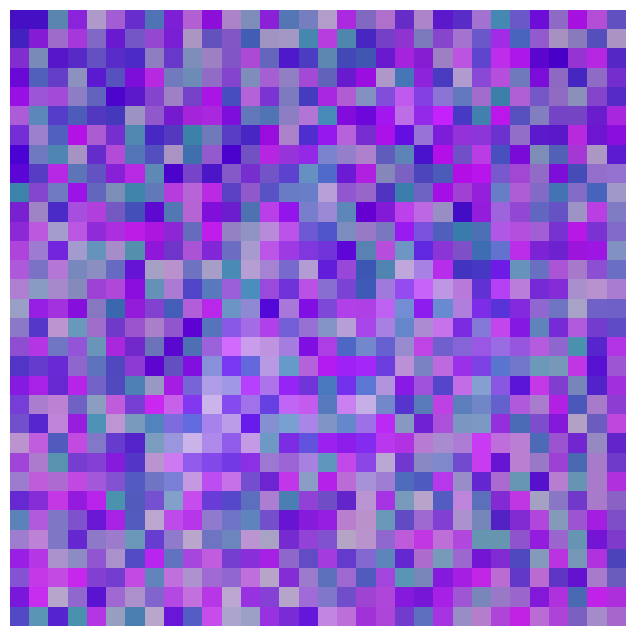

In [9]:
# Basic tensor to image display
def show_tensor_as_image(tensor):
    # Move to CPU and detach from computational graph
    tensor = tensor.detach().cpu()
    
    # Handle different tensor shapes
    if tensor.dim() == 4:  # [B, C, H, W]
        tensor = tensor[0]  # Take first batch
    
    if tensor.dim() == 3:  # [C, H, W]
        if tensor.shape[0] == 1:  # Grayscale [1, H, W]
            tensor = tensor.squeeze(0)  # Remove channel dim -> [H, W]
        elif tensor.shape[0] == 3:  # RGB [3, H, W]
            tensor = tensor.permute(1, 2, 0)  # -> [H, W, 3]
    
    # Convert to numpy
    img = tensor.numpy()
    
    # Normalize if values are not in [0, 1] range
    if img.max() > 1.0 or img.min() < 0.0:
        img = (img - img.min()) / (img.max() - img.min())
    
    # Display
    plt.figure(figsize=(8, 8))
    if len(img.shape) == 2:  # Grayscale
        plt.imshow(img, cmap='gray')
    else:  # RGB
        plt.imshow(img)
    plt.axis('off')
    plt.show()

show_tensor_as_image(out)

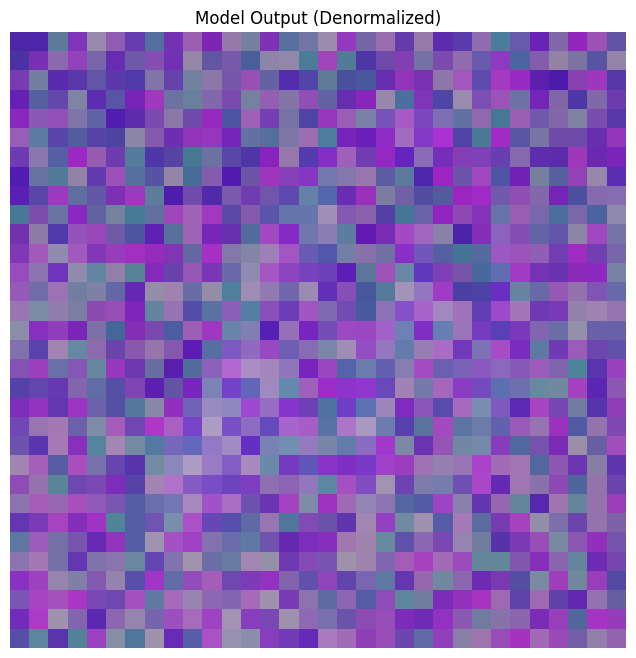

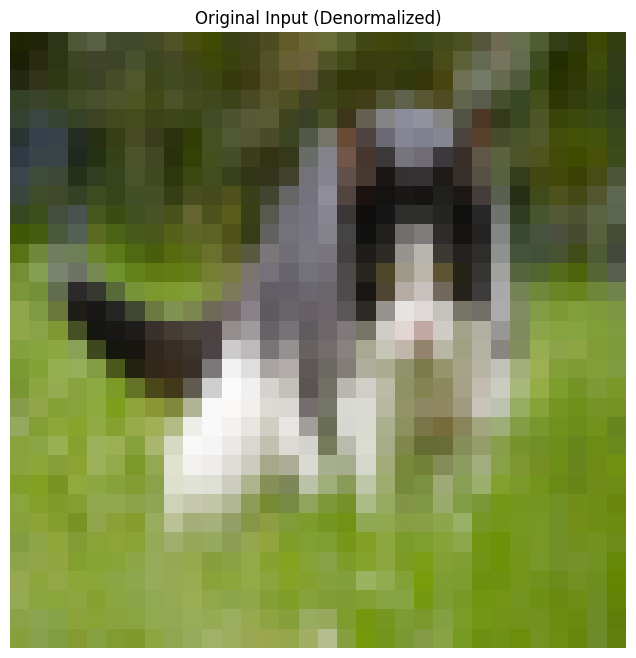

tensor([[[0.1216, 0.1294, 0.1804,  ..., 0.1922, 0.2431, 0.2039],
         [0.1098, 0.1647, 0.1843,  ..., 0.1843, 0.2471, 0.2000],
         [0.1412, 0.2039, 0.1961,  ..., 0.1922, 0.2275, 0.1922],
         ...,
         [0.5843, 0.5412, 0.5373,  ..., 0.4275, 0.4235, 0.3882],
         [0.5529, 0.5451, 0.5255,  ..., 0.4118, 0.4275, 0.3686],
         [0.5333, 0.5373, 0.5059,  ..., 0.4000, 0.4275, 0.3765]],

        [[0.1490, 0.1490, 0.2078,  ..., 0.2235, 0.2824, 0.2431],
         [0.1255, 0.1686, 0.2118,  ..., 0.2157, 0.2941, 0.2431],
         [0.1647, 0.2039, 0.2275,  ..., 0.2275, 0.2784, 0.2353],
         ...,
         [0.6667, 0.6431, 0.6471,  ..., 0.5529, 0.5490, 0.5137],
         [0.6353, 0.6431, 0.6392,  ..., 0.5373, 0.5490, 0.4941],
         [0.6235, 0.6314, 0.6157,  ..., 0.5216, 0.5490, 0.4980]],

        [[0.0118, 0.0353, 0.0941,  ..., 0.0510, 0.0314, 0.0745],
         [0.0275, 0.0588, 0.0824,  ..., 0.0118, 0.0431, 0.0980],
         [0.0706, 0.0941, 0.0824,  ..., 0.0275, 0.0510, 0.

In [10]:
def denormalize_image(tensor, title="Denormalized Image"):
    """Denormalize from [-1, 1] back to [0, 1] and display"""
    tensor = tensor.detach().cpu()
    
    if tensor.dim() == 4:
        tensor = tensor[0]  # Take first batch
    
    # Reverse the normalization: (x - 0.5) / 0.5
    # So: x_original = (x_normalized * 0.5) + 0.5
    denormalized = tensor * 0.5 + 0.5
    
    # Clamp to valid [0, 1] range
    denormalized = torch.clamp(denormalized, 0, 1)
    
    # Convert to display format [H, W, C]
    if denormalized.shape[0] == 3:
        img = denormalized.permute(1, 2, 0)
    else:
        img = denormalized
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img.numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    return denormalized

denormalize_image(out, "Model Output (Denormalized)")
denormalize_image(inpt, "Original Input (Denormalized)")

=== ORIGINAL INPUT ===


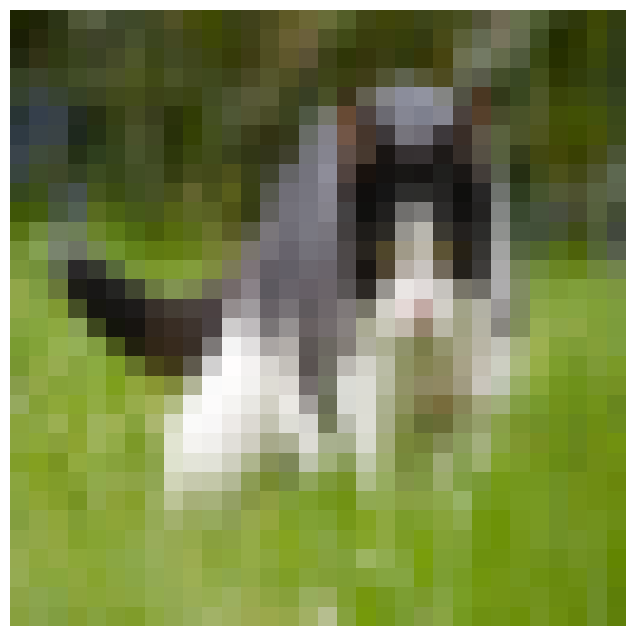

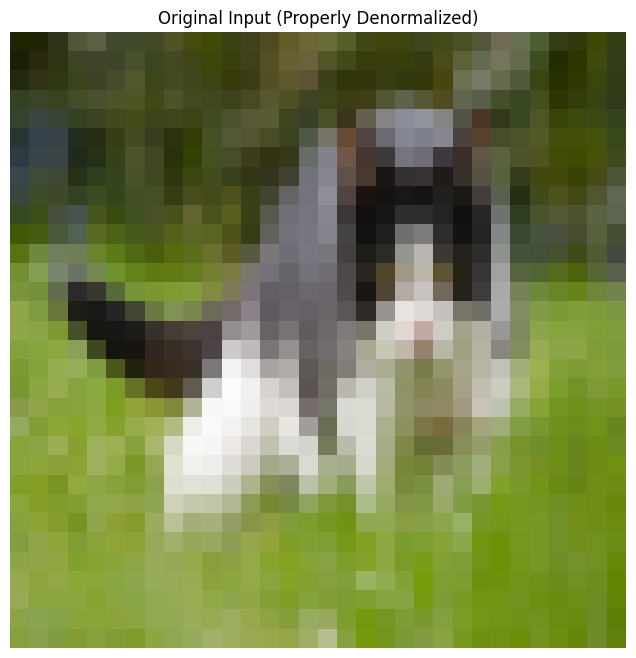


=== MODEL OUTPUT ===


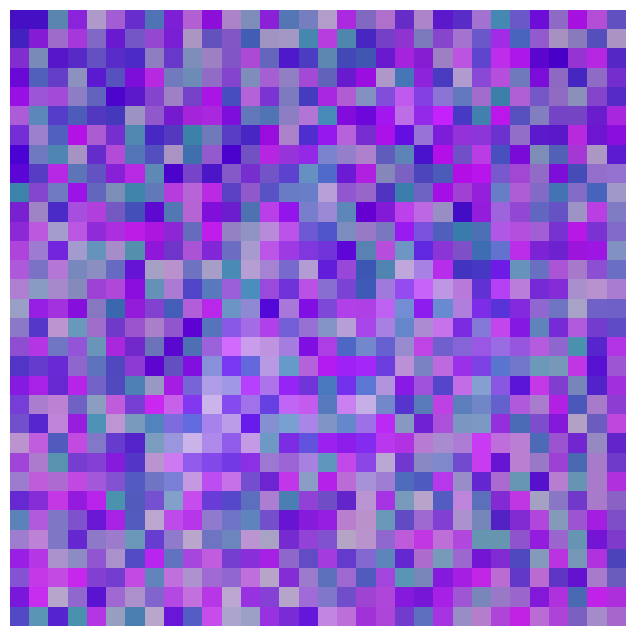

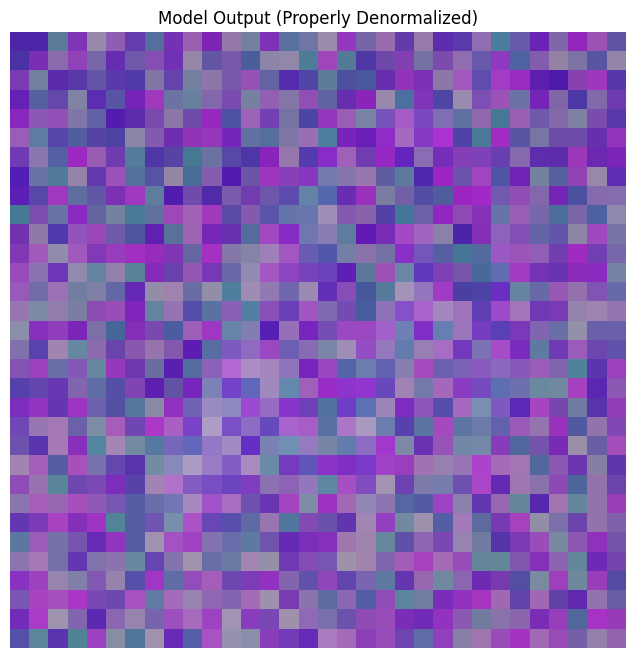


=== COORDINATE VISUALIZATION ===


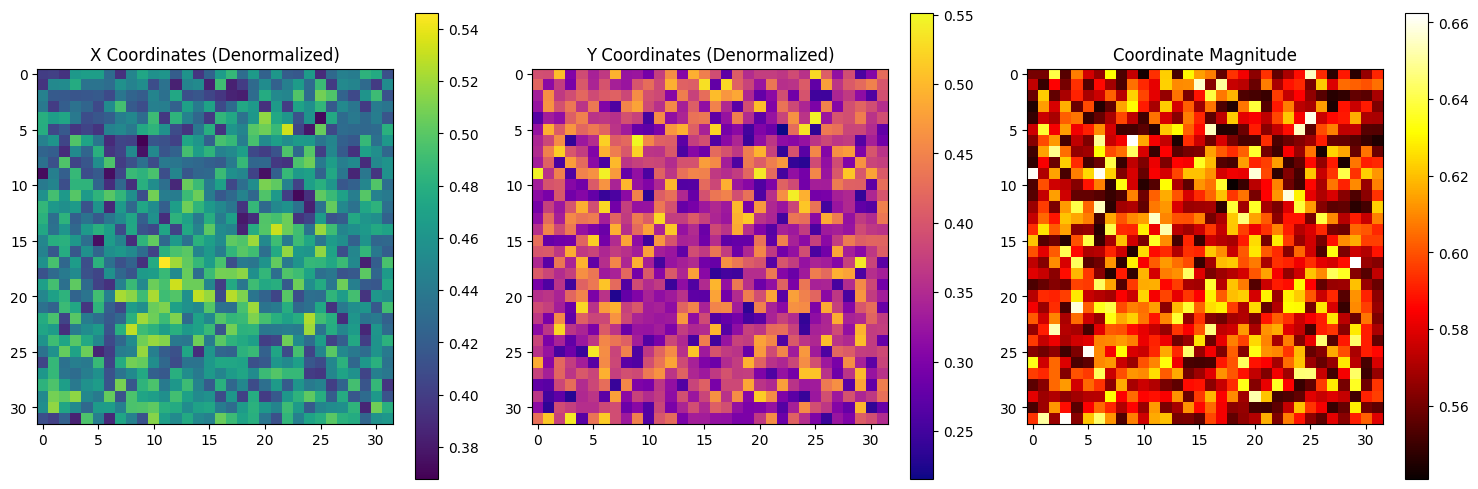

In [11]:
print("=== ORIGINAL INPUT ===")
show_tensor_as_image(inpt)
denormalize_image(inpt, "Original Input (Properly Denormalized)")

print("\n=== MODEL OUTPUT ===") 
show_tensor_as_image(out) 
denormalize_image(out, "Model Output (Properly Denormalized)")

print("\n=== COORDINATE VISUALIZATION ===")
def show_zeta_coordinates(zeta, batch_idx=0):
    zeta = zeta.detach().cpu()
    x_coords = zeta[batch_idx, 0]
    y_coords = zeta[batch_idx, 1]
    
    # Denormalize coordinates too
    x_coords = x_coords * 0.5 + 0.5
    y_coords = y_coords * 0.5 + 0.5
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(x_coords.numpy(), cmap='viridis')
    plt.title('X Coordinates (Denormalized)')
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.imshow(y_coords.numpy(), cmap='plasma')
    plt.title('Y Coordinates (Denormalized)')
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    magnitude = torch.sqrt(x_coords**2 + y_coords**2)
    plt.imshow(magnitude.numpy(), cmap='hot')
    plt.title('Coordinate Magnitude')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

show_zeta_coordinates(zeta)

# **Data Prepocessing**

In [12]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transforms=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Đọc ảnh và mask
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        
        mask = np.where(mask < 85, 0, np.where(mask < 170, 1, 2))
        
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        mask = mask.long() if isinstance(mask, torch.Tensor) else torch.from_numpy(mask).long()
        return image, mask

In [13]:
def compute_multi_iou(outputs, masks, num_classes=3):
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)
    iou_per_class = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        target_cls = (masks == cls)
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        iou = (intersection / (union + 1e-8)).item()
        iou_per_class.append(iou)
    return np.mean(iou_per_class)

def compute_dice_score(outputs, masks, num_classes=3):
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)
    dice_per_class = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        target_cls = (masks == cls)
        intersection = (pred_cls & target_cls).sum().float()
        dice = (2. * intersection / (pred_cls.sum() + target_cls.sum() + 1e-8)).item()
        dice_per_class.append(dice)
    return np.mean(dice_per_class)

def compute_precision(outputs, masks, num_classes=3):
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)
    precision_per_class = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        target_cls = (masks == cls)
        true_positive = (pred_cls & target_cls).sum().float()
        predicted_positive = pred_cls.sum().float()
        precision = (true_positive / (predicted_positive + 1e-8)).item()
        precision_per_class.append(precision)
    return np.mean(precision_per_class)

def compute_accuracy(outputs, masks):
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)
    correct = (preds == masks).sum().float()
    total = torch.numel(masks)
    return (correct / total).item()


def post_process(mask, kernel_size=3):
    import cv2
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    cleaned = cv2.morphologyEx(mask.numpy().astype(np.uint8), 
                              cv2.MORPH_OPEN, kernel)

    cleaned = cv2.morphologyEx(cleaned, 
                              cv2.MORPH_CLOSE, kernel)
    
    return torch.from_numpy(cleaned)

In [14]:
class Mixup:
    def __init__(self, alpha=0.4, p=0.5):
        self.alpha = alpha
        self.p = p
        
    def __call__(self, images, masks):
        if np.random.rand() < self.p:
            batch_size = len(images) if isinstance(images, list) else 1
            if batch_size > 1:
                indices = np.random.permutation(batch_size)
                img2, mask2 = images[indices], masks[indices]
                
                lam = np.random.beta(self.alpha, self.alpha)

                mixed_img = lam * images + (1 - lam) * img2
                mixed_mask = lam * masks + (1 - lam) * mask2
                
                return mixed_img, mixed_mask
        return images, masks

In [15]:
def get_train_transform():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

def get_valid_transform():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

# **Train**

In [16]:
def visualize_predictions(model, dataloader, device, num_samples=4):
    model.eval()
    images, masks, preds = [], [], []
    
    with torch.no_grad():
        for img, mask in dataloader:
            img = img.to(device)
            output = model(img)
            pred = torch.argmax(torch.softmax(output, dim=1), dim=1)
            
            for i in range(min(img.shape[0], num_samples - len(images))):
                if len(images) < num_samples:
                    images.append(img[i].cpu())
                    masks.append(mask[i].cpu())
                    preds.append(pred[i].cpu())
            
            if len(images) >= num_samples:
                break
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[i], cmap='jet')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(preds[i], cmap='jet')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    return fig

In [18]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, tau):
    model.train()
    train_loss = 0.0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs, zeta, V = model(images)
        loss = criterion(outputs, masks)*(1-tau) + V*tau
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return train_loss / len(dataloader)

# Validation function
def validate(model, dataloader, criterion, device, tau):
    model.eval()
    val_loss = 0.0
    iou_scores, dsc_scores, precision_scores, acc_scores = [], [], [], []
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validation'):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs, zeta, V = model(images)
            loss = criterion(outputs, masks)*(1-tau) + V*tau
            
            val_loss += loss.item()
            
            iou_scores.append(compute_multi_iou(outputs, masks))
            dsc_scores.append(compute_dice_score(outputs, masks))
            precision_scores.append(compute_precision(outputs, masks))
            acc_scores.append(compute_accuracy(outputs, masks))
    
    mean_iou = np.mean(iou_scores)
    mean_dsc = np.mean(dsc_scores)
    mean_precision = np.mean(precision_scores)
    mean_acc = np.mean(acc_scores)
    
    return val_loss / len(dataloader), mean_iou, mean_dsc, mean_precision, mean_acc

In [19]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, device, fold=None):
    best_metrics = {'mean_iou': 0.0, 'mean_dsc': 0.0}
    history = {
        'train_loss': [], 'val_loss': [],
        'iou': [], 'dsc': [], 'precision': [], 'accuracy': []
    }
    
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, tau = 0.5)
        history['train_loss'].append(train_loss)
        
        val_loss, mean_iou, mean_dsc, mean_precision, mean_acc = validate(model, val_loader, criterion, device, tau = 0.5)
        history['val_loss'].append(val_loss)
        history['iou'].append(mean_iou)
        history['dsc'].append(mean_dsc)
        history['precision'].append(mean_precision)
        history['accuracy'].append(mean_acc)
        
        scheduler.step(mean_dsc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Accuracy: {mean_acc:.4f}, Mean IoU: {mean_iou:.4f}, Mean DSC/F1: {mean_dsc:.4f}, Mean Precision: {mean_precision:.4f}")
        
        if mean_dsc > best_metrics['mean_dsc']:
            best_metrics['mean_dsc'] = mean_dsc
            best_metrics['mean_iou'] = mean_iou
            best_metrics['mean_precision'] = mean_precision
            best_metrics['mean_acc'] = mean_acc
            
            model_name = f"best_model_fold{fold}.pth" if fold is not None else "best_model.pth"
            torch.save(model.state_dict(), model_name)
            print(f"Saved best model with DSC: {mean_dsc:.4f}")
        
        print(f"Best DSC: {best_metrics['mean_dsc']:.4f}, Best IoU: {best_metrics['mean_iou']:.4f}")
        print("-" * 50)
    
    return model, history, best_metrics

In [22]:
def find_optimal_k(all_images, all_masks, k_values=[3, 5, 7, 10], num_epochs=10, tau = 0.5):

    k_scores = []
    k_variances = []
    train_times = []
    
    for k in k_values:
        fold_scores = []
        
        kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
        start_time = time.time()
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(all_images)):
            print(f"  Fold {fold+1}/{k}")
            
            train_img = [all_images[i] for i in train_idx]
            train_mask = [all_masks[i] for i in train_idx]
            val_img = [all_images[i] for i in val_idx]
            val_mask = [all_masks[i] for i in val_idx]
            
            # Tạo dataset
            train_dataset = SegmentationDataset(train_img, train_mask, get_train_transform())
            val_dataset = SegmentationDataset(val_img, val_mask, get_valid_transform())
            
            # Tạo dataloader
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
            
            # Khởi tạo model mới cho mỗi fold
            model = ElectricForceModel().to(DEVICE)
            
            # Setup optimizer và loss
            optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
            criterion = nn.CrossEntropyLoss()
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)
            
            best_metrics = {'mean_dsc': 0.0}
            
            for epoch in range(num_epochs):
                model.train()
                for images, masks in train_loader:
                    images, masks = images.to(DEVICE), masks.to(DEVICE)
                    optimizer.zero_grad()
                    outputs, zeta, V = model(images)
                    loss = criterion(outputs, masks)*(1-tau) + V*tau
                    loss.backward()
                    optimizer.step()
                
                model.eval()
                dsc_scores = []
                with torch.no_grad():
                    for images, masks in val_loader:
                        images, masks = images.to(DEVICE), masks.to(DEVICE)
                        outputs, zeta, V = model(images)
                        dsc_scores.append(compute_dice_score(outputs, masks))
                
                mean_dsc = np.mean(dsc_scores)
                scheduler.step(mean_dsc)
                
                if mean_dsc > best_metrics['mean_dsc']:
                    best_metrics['mean_dsc'] = mean_dsc
            
            # Lưu Dice score của fold này
            fold_scores.append(best_metrics['mean_dsc'])
            print(f"    Dice score: {best_metrics['mean_dsc']:.4f}")
        
        train_time = time.time() - start_time
        train_times.append(train_time)
        
        mean_score = np.mean(fold_scores)
        score_variance = np.var(fold_scores)
        
        k_scores.append(mean_score)
        k_variances.append(score_variance)
        
        print(f"K={k}, Điểm trung bình: {mean_score:.4f}, Phương sai: {score_variance:.6f}")
        print(f"Thời gian training: {train_time:.2f} giây")
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    ax1.plot(k_values, k_scores, 'o-', linewidth=2, color='blue')
    ax1.set_xlabel('Số lượng Fold (K)')
    ax1.set_ylabel('Điểm DSC trung bình')
    ax1.set_title('Hiệu suất theo giá trị K')
    ax1.grid(True)
    
    # Vẽ phương sai
    ax2.plot(k_values, k_variances, 'o-', linewidth=2, color='orange')
    ax2.set_xlabel('Số lượng Fold (K)')
    ax2.set_ylabel('Phương sai')
    ax2.set_title('Phương sai theo giá trị K')
    ax2.grid(True)
    
    # Vẽ thời gian training
    ax3.plot(k_values, train_times, 'o-', linewidth=2, color='green')
    ax3.set_xlabel('Số lượng Fold (K)')
    ax3.set_ylabel('Thời gian training (giây)')
    ax3.set_title('Thời gian training theo giá trị K')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.savefig('k_fold_elbow_analysis.png')
    plt.show()
    
    optimal_k = find_elbow_point(k_values, k_scores, k_variances)

    
    return optimal_k

def find_elbow_point(k_values, k_scores, k_variances):
    """
    Xác định điểm elbow dựa trên phần trăm cải thiện và phương sai
    """
    
    improvements = []
    for i in range(1, len(k_values)):
        improvement = (k_scores[i] - k_scores[i-1]) / k_scores[i-1] * 100
        improvements.append(improvement)
    
    for i in range(len(improvements)):
        if improvements[i] < 1.0:
            return k_values[i+1]
    
    var_index = np.argmin(k_variances)
    return k_values[var_index]

In [23]:
def run_training():
    print(f"Using device: {DEVICE}")
    
    root_dir = Path('/kaggle/input/data-1/content')
    all_images = sorted(list((root_dir / 'images').glob('*.bmp')))
    all_masks = sorted(list((root_dir / 'masks').glob('*.png')))
    
    all_images = sorted(all_images, key=lambda x: x.stem)
    all_masks = sorted(all_masks, key=lambda x: x.stem)
    
    print(f"Total images: {len(all_images)}")
    print(f"Total masks: {len(all_masks)}")
    
    optimal_k = find_optimal_k(
        all_images, all_masks, 
        k_values=[3, 5, 7, 10], 
        num_epochs=10
    )
    
    kf = KFold(n_splits=optimal_k, shuffle=True, random_state=SEED)
    fold_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(all_images)):
        print(f"Training Fold {fold+1}/{optimal_k}")

        train_img = [all_images[i] for i in train_idx]
        train_mask = [all_masks[i] for i in train_idx]
        val_img = [all_images[i] for i in val_idx]
        val_mask = [all_masks[i] for i in val_idx]
        
        # Create datasets
        train_dataset = SegmentationDataset(train_img, train_mask, get_train_transform())
        val_dataset = SegmentationDataset(val_img, val_mask, get_valid_transform())
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        
        # Initialize model
        model = ElectricForceModel().to(DEVICE)
        
        # Setup optimizer and loss
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)
        
        # Train model
        model, history, best_metrics = train_model(
            model, 
            train_loader, 
            val_loader,
            optimizer,
            criterion,
            scheduler,
            NUM_EPOCHS,
            DEVICE,
            fold=fold
        )
        
        # Save metrics
        fold_metrics.append(best_metrics)
        
        # Visualize predictions
        visualize_predictions(model, val_loader, DEVICE)
        
        # Plot learning curves
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss Curves')
        
        plt.subplot(2, 2, 2)
        plt.plot(history['iou'], label='IoU')
        plt.plot(history['dsc'], label='DSC/F1')
        plt.legend()
        plt.title('IoU and DSC Curves')
        
        plt.subplot(2, 2, 3)
        plt.plot(history['precision'], label='Precision')
        plt.legend()
        plt.title('Precision Curve')
        
        plt.subplot(2, 2, 4)
        plt.plot(history['accuracy'], label='Accuracy')
        plt.legend()
        plt.title('Accuracy Curve')
        
        plt.tight_layout()
        plt.savefig(f'learning_curves_fold{fold}.png')
        plt.show()
    
    # Print overall metrics
    print("\nAverage metrics across all folds:")
    avg_iou = np.mean([metrics['mean_iou'] for metrics in fold_metrics])
    avg_dsc = np.mean([metrics['mean_dsc'] for metrics in fold_metrics])
    avg_precision = np.mean([metrics['mean_precision'] for metrics in fold_metrics])
    avg_acc = np.mean([metrics['mean_acc'] for metrics in fold_metrics])
    
    print(f"Avg IoU: {avg_iou:.4f}")
    print(f"Avg DSC/F1: {avg_dsc:.4f}")
    print(f"Avg Precision: {avg_precision:.4f}")
    print(f"Avg Accuracy: {avg_acc:.4f}")

# Run the training
if __name__ == "__main__":
    run_training()

Using device: cuda
Total images: 300
Total masks: 300
  Fold 1/3


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1, 1024, 2]], which is output 0 of AsStridedBackward0, is at version 4; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).